## Create and test ion channel model

In [1]:
from experiments.ina_sakakibara import (sakakibara_iv,
                                        sakakibara_iv_Nao2 ,
                                        sakakibara_iv_Nao5 ,
                                        sakakibara_iv_Nao20 ,
                                        sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        sakakibara_inact_kin_2,
                                        sakakibara_inact_kin_80,
                                        sakakibara_inact_kin_100,
                                        sakakibara_recov,
                                        sakakibara_recov_100,
                                        sakakibara_recov_kin)
from experiments.ina_schneider import (schneider_iv,
                                    schneider_tauf,
                                    schneider_taum,
                                    schneider_taus,
                                      schneider_inact,
                                       schneider_inact_128,
                                      schneider_reduc,
                                       schneider_reduc_95,
                                      schneider_recov,
                                      schneider_recov_95)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [2]:
modelfile = 'models/ina_simple.mmt'

In [3]:
observations, model, summary_statistics = setup(modelfile,sakakibara_iv,sakakibara_act,sakakibara_inact,sakakibara_inact_kin_100
                                                ,sakakibara_recov_100
                                            )
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [88]:
#'ina.A' : (0,1) was not taken into account after realising that it slowed down a lot the convergence process
# probably because if the wrong A is chosen, the whole result will fail no matter the other parameters

#'log_ina.g_Na' : (-4,2), : only for IV curve runs

limitssemilog = {
'log_ina.g_Na' : (-4,2),
'log_ina.p_1' :(-7,3),
'ina.p_2' : (0,100),
'log_ina.p_3' : (-7,0),
'ina.p_4' : (-1,1),
'log_ina.p_5' : (-7,1),
'ina.p_6' : (0,1),
'log_ina.p_7' : (-8,-3),
'ina.p_8' : (0,1),
'log_ina.p_9' : (-7,1),
'ina.p_10' : (0,1) }

limitslog = {   
'ina.A' : (0,1),
'log_ina.g_Na' : (-4,2),
'log_ina.p_1' :(-7,0),
'log_ina.p_2' : (-8,4),
'log_ina.p_3' : (-7,-1),
'log_ina.p_4' : (-8,0),
'log_ina.p_5' : (-7,-3),
'log_ina.p_6' : (-8,-2),
'log_ina.p_7' : (-11,-2),
'log_ina.p_8' : (-7,-3),
'log_ina.p_9' : (-7,-3),
'log_ina.p_10' : (-7,0) }

limits = limitssemilog
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [19]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "simple_ina_testing.db"))

In [20]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [21]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [13]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000), # Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=1.30),
             sampler=MulticoreEvalParallelSampler(n_procs=40),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.745305411007093, '1': 1.745305411007093, '2': 1.745305411007093, '3': 1.0392127636280601, '4': 0.3286811654596004, '5': 0.29088423516784884, '6': 0.3271755036497608, '7': 0.4166274167618244, '8': 0.5471502142009478, '9': 1.086382444332294, '10': 1.745305411007093, '11': 1.3764267901961535, '12': 0.6604258723780589, '13': 0.4322085660306067, '14': 0.3340222190600802, '15': 1.0471832466042559, '16': 1.0471832466042559, '17': 1.0471832466042559, '18': 1.0471832466042559, '19': 1.0471832466042559, '20': 1.0471832466042559, '21': 1.0471832466042559, '22': 1.0471832466042559, '23': 1.0471832466042559, '24': 1.0471832466042559, '25': 1.0471832466042559, '26': 1.0471832466042559, '27': 1.0471832466042559, '28': 1.0471832466042559, '29': 1.0471832466042559, '30': 1.0471832466042559, '31': 1.0471832466042559, '32': 1.0471832466042559, '33': 1.0471832466042559, '34': 1.0471832466042559, '35': 1.0471832466042559, '36': 1.0471832466042559, '37': 1.047183246604

In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc.load(db_path,41)

41

In [15]:
#abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=41, start_time=2019-09-13 04:07:28.883930, end_time=None)>


In [18]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0)

INFO:ABC:t:19 eps:1.031297770112802
DEBUG:ABC:now submitting population 19
DEBUG:ABC:population 19 done
DEBUG:ABC:
total nr simulations up to t =19 is 10867213
DEBUG:Epsilon:new eps, t=20, eps=1.0199835285337548
INFO:ABC:t:20 eps:1.0199835285337548
DEBUG:ABC:now submitting population 20
Process Process-428:
Process Process-431:
Process Process-438:
Process Process-432:
Process Process-437:
Process Process-422:
Process Process-423:
Process Process-436:
Process Process-433:
Process Process-434:
Process Process-409:
Process Process-405:
Process Process-408:
Process Process-440:
Process Process-410:
Process Process-414:
Process Process-421:
Process Process-403:
Process Process-429:
Process Process-417:
Process Process-420:
Process Process-427:
/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/experiment.py:212: UserWarning: Could not set value of ina.p_6
Process Process-407:
Process Process-435:
Traceback (most recent call last):
  File "/home/brm18

KeyboardInterrupt: 

  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 545, in simulate_one
    transitions)
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/brm18/.local/lib/python3.7/site-package


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/brm18/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py", line 443, in pdf
    return self.dist.pdf(x, *self.args, **self.kwds)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/model.py", line 222, in accept
    sum_stats_calculator)
  File "/home/brm18/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py", line 443, in pdf
    return self.dist.pdf(x, *self.args, **self.kwds)
  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/experiment.py", line 235, in summary_statistics
    for i, val in enumerate(sum_stats_combined(data))}
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/random_variables.py", line 189, in pdf
    return self.distribu

  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/utils.py", line 58, in rvs
    return self.rvs_single()
  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/experiment.py", line 25, in sum_stats_fn
    sum_stats = sum_stats+f(x[i])
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/numpy/core/numerictypes.py", line 655, in find_common_type
    scalar_types = [dtype(x) for x in scalar_types]
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/dtypes/dtypes.py", line 461, in construct_from_string
    raise TypeError("cannot construct a CategoricalDtype")
  File "/home/brm18/New Ion channel/ion-channel-ABC/docs/examples/Nygren/experiments/ina_schneider.py", line 496, in schneider_inact_128_sum_stats
    for d in data.split_periodic(tperiod_inact_128_sch, adjust=True):
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_e

  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/utils.py", line 58, in rvs
    return self.rvs_single()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/multivariatenormal.py", line 73, in rvs_single
    sample = self.X.sample(weights=self.w).iloc[0]
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 607, in _generate_valid_proposal
    theta_ss = transitions[m_ss].rvs()
KeyboardInterrupt
  File "/home/brm18/.local/lib/python3.7/site-packages/myokit/_datalog.py", line 1237, in trim_left
    log = self.itrim_left(self.find(value))
  File "/home/brm18/.local/lib/python3.7/site-packages/myokit/_datalog.py", line 1124, in split_periodic
    while k < nlogs and t >= tstarts[k]:
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 37, in rvs_single
    return f(self)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta

  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/utils.py", line 58, in rvs
    return self.rvs_single()
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/generic.py", line 4842, in sample
    if weights.sum() != 0:
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
  File "/home/brm18/.local/lib/python3.7/site-packages/scipy/linalg/decomp_svd.py", line 121, in svd
    gesXd, gesXd_lwork = get_lapack_funcs(funcs, (a1,))
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/generic.py", line 4838, in sample
    weights = weights.fillna(0)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 37, in rvs_single
    return f(self)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in

KeyboardInterrupt
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 1524, in dtype
    return self._block.dtype
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/internals/construction.py", line 572, in sanitize_array
    subarr = _try_cast(data, True, dtype, copy, raise_cast_failure)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 37, in rvs_single
    return f(self)
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 395, in apply
    applied = getattr(b, f)(**kwargs)
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/numpy/core/numerictypes.py", line 328, in issubclass_
    return issubclass(arg1, arg2)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 37, in rvs_single
    return f(self)
  File "/apps/anaconda/anaconda3-201

  File "<frozen importlib._bootstrap>", line 1019, in _handle_fromlist
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/internals/blocks.py", line 3062, in get_block_type
    elif is_extension_array_dtype(values):
KeyboardInterrupt
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/dtypes/common.py", line 1702, in is_extension_array_dtype
    def is_extension_array_dtype(arr_or_dtype):
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 545, in simulate_one
    transitions)
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/dtypes/base.py", line 112, in is_dtype
    return cls.construct_from_string(dtype) is not None
KeyboardInterrupt
  File "/home/brm18/.local/lib/python3

# Results analysis

/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


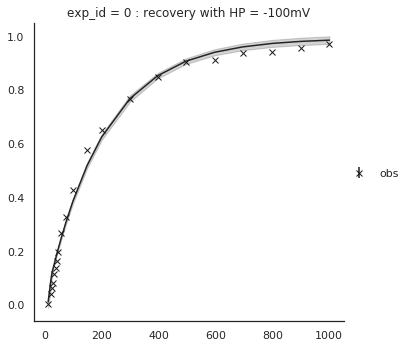

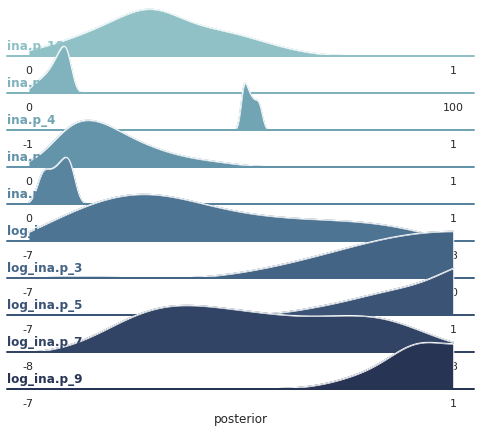

In [89]:
history = History(db_path)
history.id = 8

#Sakakibara experiments :

# IV 5 mM corresponds to sakakibara_iv_Nao5 ,
# act corresponds to sakakibara_act,
# inact corresponds to sakakibara_inact
# time constants corresponds to sakakibara_inact_kin_1
# recovery HP = -100 mv corresponds to sakakibara_recov_100
# availablity HP = -100 mv corresponds to sakakibara_inact_kin_100
# all experiments corresponds to sakakibara_iv (not Nao5),sakakibara_act,sakakibara_inact,
#                                sakakibara_inact_kin_1,sakakibara_recov_100,sakakibara_inact_kin_100


# history.id correspondance :

# for plotting the posterior of following runs, load the limit : limitssemilog

# 8 : recovery HP = -100 mV : success
# 13 : time constants : success
# 14 : IV 5 mM, act and inact : success
# 24 : all experiments : success

#Schneider experiments :

# IV corresponds to schneider_iv,
# inact corresponds to schneider_inact_128
# availability corresponds to schneider_reduc_95
# recovery corresponds to schneider_recov_95

# history.id correspondance :

# for plotting the posterior of following runs, load the limit : limitssemilog

# 33 : IV , eps = 0.25 (21 iter) : Success 

# for plotting the posterior of following runs, load the limit : limitslog

# 37 : inact , eps = 0.223 (36 iter) : medium success, the bounds are respected but the curve is not perfect. 
# 39 : Availability, eps = 0.37 (21 iter) : fail 
# 40 : Recovery (recov_95) , eps = 0.80 (22 iter) : fail 
# 41 : IV + inact_128 , eps = 1.30 (10 iter) : success but needs to continue running for adjusting g_Na 
df, w = history.get_distribution(m=0)

grid1 = plot_sim_results(modelfile,
                         sakakibara_recov_100
                                                 ,df=df, w=w,n_samples=100) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)
#df.describe()